[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/iterative_sense_reconstruction_radial2D.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:iterative_sense_reconstruction_radial2D.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

# Iterative SENSE reconstruction of 2D golden angle radial data
Here we use an iterative reconstruction method to reconstruct images from ISMRMRD 2D radial data.

We use the `~mrpro.algorithms.reconstruction.IterativeSENSEReconstruction` class to solve
the following reconstruction problem:

Let's assume we have obtained the k-space data $y$ from an image $x$ with an acquisition model (Fourier transforms,
coil sensitivity maps...) $A$ then we can formulate the forward problem as:

$ y = Ax + n $

where $n$ describes complex Gaussian noise. The image $x$ can be obtained by minimizing the functional $F$

$ F(x) = ||Ax - y||_2^2 $

Setting the derivative of the functional $F$ to zero and rearranging yields

$ A^H A x = A^H y$

which is a linear system $Hx = b$ that needs to be solved for $x$. This is done using the conjugate gradient method.

```{note}
In [Pruessmann et al. 2001](https://doi.org/10.1002/mrm.1241) the k-space density is used to reweight the
loss to achieve faster convergence. This increases reconstruction error, see [Ong F., Uecker M., Lustig M. 2020](https://doi.org/10.1109/TMI.2019.2954121).
We follow a recommendation by [Fessler and Noll](https://ece-classes.usc.edu/ee591/library/Fessler-Iterative%20Reconstruction.pdf)
and use the DCF to obtain a good starting point.
```

## Using `~mrpro.algorithms.reconstruction.IterativeSENSEReconstruction`
First, we demonstrate the use of `~mrpro.algorithms.reconstruction.IterativeSENSEReconstruction`, before we
peek behind the scenes and implement the reconstruction manually.

## Read-in the raw data
We read the raw k-space data and the trajectory from the ISMRMRD file
(see <project:comparison_trajectory_calculators.ipynb> for more information on the trajectory calculation).
Our example data contains three datasets:
- ``radial2D_402spokes_golden_angle_with_traj.h5`` with 402 spokes
- ``radial2D_96spokes_golden_angle_with_traj.h5`` with 96 spokes
- ``radial2D_24spokes_golden_angle_with_traj.h5`` with 24 spokes

We use the 402 spokes dataset for the reconstruction.

In [2]:
# ### Download raw data from Zenodo
import tempfile
from pathlib import Path

import zenodo_get

dataset = '14617082'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Radial MR raw data and Pulseq sequences
Keywords: 
Publication date: 2025-01-08
DOI: 10.5281/zenodo.14617082
Total size: 18.7 MB

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle_with_traj.h5   size: 858.7 kB



Checksum is correct. (9a82b5f9c6f27a3db64fd8f7be65cfa3)

Link: https://zenodo.org/records/14617082/files/radial2D_24spokes_golden_angle.seq   size: 29.3 kB



Checksum is correct. (d48ba3340d511a7e24dfc69031a3b6ac)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle.seq   size: 172.2 kB



Checksum is correct. (ff682e21d7d2434dc5b672523dfeacec)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle_with_traj.h5   size: 3.4 MB



Checksum is correct. (9fc6d03790b1cf293cbd83939a1dd752)

Link: https://zenodo.org/records/14617082/files/radial2D_402spokes_golden_angle_with_traj.h5   size: 14.2 MB



Checksum is correct. (54d083c0040d3674317006cbaaa95420)

Link: https://zenodo.org/records/14617082/files/radial2D_96spokes_golden_angle.seq   size: 55.9 kB



Checksum is correct. (449434bf7b5e609d09cf5d42cf27c7f3)
All files have been downloaded.


In [3]:
import mrpro

trajectory_calculator = mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
kdata = mrpro.data.KData.from_file(data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5', trajectory_calculator)

## Direct reconstruction for comparison
For comparison, we first can carry out a direct reconstruction using the
`~mrpro.algorithms.reconstruction.DirectReconstruction` class.
See also <project:direct_reconstruction.ipynb>.

In [4]:
direct_reconstruction = mrpro.algorithms.reconstruction.DirectReconstruction(kdata)
img_direct = direct_reconstruction(kdata)

### Setting up the iterative SENSE reconstruction
Now let's use the `~mrpro.algorithms.reconstruction.IterativeSENSEReconstruction` class to reconstruct the image
using the iterative SENSE algorithm.

We first set up the reconstruction. Here, we reuse the the Fourier operator, the DCFs and the coil sensitivity maps
from ``direct_reconstruction``. We use *early stopping* after 4 iterations by setting `n_iterations`.

```{note}
When setting up the reconstruction we can also provide the `~mrpro.data.KData` and let
 `~mrpro.algorithms.reconstruction.IterativeSENSEReconstruction` figure
out the Fourier operator, estimate the coil sensitivity maps, and choose a density weighting.\
We can also provide `~mrpro.data.KData` and some information, such as the sensitivity maps.
In that case, the reconstruction will automatically determine the missing information based
on the `~mrpro.data.KData` object.
```

In [5]:
iterative_sense_reconstruction = mrpro.algorithms.reconstruction.IterativeSENSEReconstruction(
    fourier_op=direct_reconstruction.fourier_op,
    csm=direct_reconstruction.csm,
    dcf=direct_reconstruction.dcf,
    n_iterations=4,
)

### Run the reconstruction
We now run the reconstruction using ``iterative_sense_reconstruction`` object. We just need to pass the k-space data
and obtain the reconstructed image as `~mrpro.data.IData` object.

In [6]:

img = iterative_sense_reconstruction(kdata)

## Behind the scenes
We now peek behind the scenes to see how the iterative SENSE reconstruction is implemented. We perform all steps
`~mrpro.algorithms.reconstruction.IterativeSENSEReconstruction` does when initialized with only an `~mrpro.data.KData`
object, i.e., we need to set up a Fourier operator, estimate coil sensitivity maps, and the density weighting.
without reusing anything from ``direct_reconstruction```.

### Set up the acquisition model $A$
We need `~mrpro.operators.FourierOp` and `~mrpro.operators.SensitivityOp` operators to set up the acquisition model
$A$. The Fourier operator is created from the trajectory and header information in ``kdata``:

In [7]:
fourier_operator = mrpro.operators.FourierOp(
    traj=kdata.traj,
    recon_matrix=kdata.header.recon_matrix,
    encoding_matrix=kdata.header.encoding_matrix,
)

To estimate the coil sensitivity maps, we first calculate the coil-wise images from the k-space data and then
estimate the coil sensitivity maps using the Walsh method.
We use the Voronoi tessellation to calculate the density compensation.

In [8]:
dcf_operator = mrpro.data.DcfData.from_traj_voronoi(kdata.traj).as_operator()
img_coilwise = mrpro.data.IData.from_tensor_and_kheader(*fourier_operator.H(*dcf_operator(kdata.data)), kdata.header)
csm_data = mrpro.data.CsmData.from_idata_walsh(img_coilwise)
csm_operator = csm_data.as_operator()

Now we can set up the acquisition operator $A$ by composing the Fourier operator and the coil sensitivity maps
operator using ``@``.

In [9]:
acquisition_operator = fourier_operator @ csm_operator

### Calculate the right-hand-side of the linear system
Next, we need to calculate $b = A^H y$.

In [10]:
(right_hand_side,) = acquisition_operator.H(kdata.data)

### Set-up the linear self-adjoint operator $H$
We setup $H = A^H A$ using the `~mrpro.operators.LinearOperator.gram` property.

In [11]:
operator = acquisition_operator.gram

In [12]:
import torch


def vdot(u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    """Dot product of two batched 3d tensors."""
    return torch.linalg.vecdot(u.flatten(start_dim=-3), v.flatten(start_dim=-3))

### Choose initial value
We choose the initial value for the iterative reconstruction based on the density compensated adjoint reconstruction:
$u = A^H W y$. To account for normalization differences, we scale $u$ by $\frac{u^H u}{u^H A^H W A u}$.

In [13]:
(u,) = (acquisition_operator.H @ dcf_operator)(kdata.data)
scale = vdot(u, u) / vdot(u, *(acquisition_operator.H @ dcf_operator @ acquisition_operator)(u))
initial_value = u * scale

### Run conjugate gradient
Finally, we solve the linear system $Hx = b$ using the conjugate gradient method.
Again, we use early stopping after 4 iterations. Instead, we could also use a tolerance
to stop the iterations when the residual is below a certain threshold.

In [14]:
(img_manual,) = mrpro.algorithms.optimizers.cg(
    operator, right_hand_side, initial_value=initial_value, max_iterations=4, tolerance=0.0
)

## Display the results
We can now compare the results of the iterative SENSE reconstruction with the direct reconstruction.
Both versions, the one using the `~mrpro.algorithms.reconstruction.IterativeSENSEReconstruction` class
and the manual implementation should result in identical images.

In [15]:
import matplotlib.pyplot as plt


def show_images(*images: torch.Tensor, titles: list[str] | None = None) -> None:
    """Plot images."""
    n_images = len(images)
    _, axes = plt.subplots(1, n_images, squeeze=False, figsize=(n_images * 3, 3))
    for i in range(n_images):
        axes[0][i].imshow(images[i], cmap='gray')
        axes[0][i].axis('off')
        if titles:
            axes[0][i].set_title(titles[i])
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


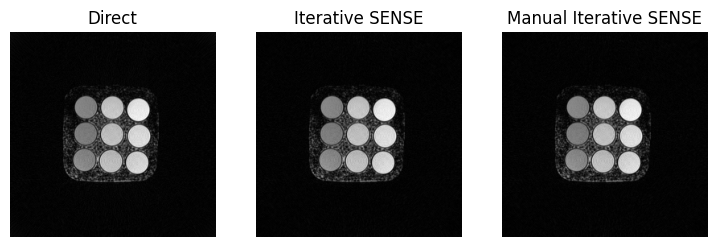

In [16]:
show_images(
    img_direct.rss()[0, 0],
    img.rss()[0, 0],
    img_manual.abs()[0, 0, 0],
    titles=['Direct', 'Iterative SENSE', 'Manual Iterative SENSE'],
)

### Check for equal results
Finally, we check if two images are really identical.

In [17]:
# If the assert statement does not raise an exception, the results are equal.
torch.testing.assert_close(img.data, img_manual)

## Next steps
We can also reconstruct undersampled data: You can replace the filename above to use a dataset with fewer spokes to
try it out.\
If you want to see how to include a regularization term in the optimization problem,
see the example in <project:iterative_sense_reconstruction_with_regularization.ipynb>.